In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from statsmodels.stats.proportion import proportion_confint

raw = pd.read_csv("credit_card_default_analysis.csv")
raw.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Поля в предоставляемых данных имеют следующий смысл:

* LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
* SEX: пол клиента (1 = мужской, 2 = женский )
* EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
* MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
* AGE: возраст в годах
* PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
* BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
* PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
* default - индикатор невозврата денежных средств

**Задание 1.** Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: 

a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки 

b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

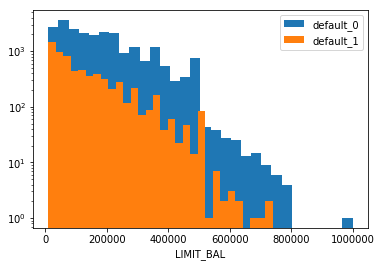

In [3]:
default_1=raw.LIMIT_BAL[raw.default==1].values
default_0=raw.LIMIT_BAL[raw.default==0].values

plt.hist(default_0, bins=30, label="default_0")
plt.hist(default_1, bins=30, label="default_1")
plt.xlabel("LIMIT_BAL")
plt.yscale('log')
plt.legend()
plt.show()

Оценка доверительных интервалов для медианных значений кредитного лимита с помощью bootstrap.

In [4]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

np.random.seed(122)

default_0_medians = list(map(np.median, get_bootstrap_samples(default_0, 1000)))
default_1_medians = list(map(np.median, get_bootstrap_samples(default_1, 1000)))

delta_medians = list(map(lambda x: x[1] - x[0], zip(default_0_medians, default_1_medians)))

print("95% доверительный интревал для разности медиан : {}".format(stat_intervals(delta_medians, 0.05)))

95% доверительный интревал для разности медиан : [-70000. -60000.]


95% доверительный интервал не включает 0, гипотиза о равенстве медиан отвергается

Для проверки гипотезы равентсва средних против двухсторонней альтернативы мы можем применить критерий Мана-Уитни.

In [5]:
p_value = stats.mannwhitneyu(default_0, default_1)[1]
print("Гипотиза о равенстве сердних книтерием Мана-Уитни{} отвергается. Достигаемый уровень значимости {} \n".format(
      "" if p_value < 0.05 else " не", p_value))

print("Среднее для default_1  {}".format(np.mean(default_1)))
print("Среднее для default_0  {}".format(np.mean(default_0)))
print("Размер эффекта: {}".format(np.mean(default_1)-np.mean(default_0)))

default_0_means = list(map(np.mean, get_bootstrap_samples(default_0, 1000)))
default_1_means = list(map(np.mean, get_bootstrap_samples(default_1, 1000)))
print("95% доверительный интревал для среднего методом bootstrap для default_1 : {}".format(stat_intervals(default_1_means, 0.05)))
print("95% доверительный интревал для среднего методом bootstrap для default_0 : {}".format(stat_intervals(default_0_means, 0.05)))


Гипотиза о равенстве сердних книтерием Мана-Уитни отвергается. Достигаемый уровень значимости 6.12774290911e-190 

Среднее для default_1  130109.65642
Среднее для default_0  178099.726074
Размер эффекта: -47990.0696548
95% доверительный интревал для среднего методом bootstrap для default_1 : [127169.97317661 132789.08378541]
95% доверительный интревал для среднего методом bootstrap для default_0 : [176394.18549906 179811.875107  ]


Считаю, что полученный результат значим с практической точки зрения, так как разница средних размеров кредитного лимита для тех кто не вернул кридит меньше на ~30%

**Задание 2.** Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

Женщин в default_0 : 0.614149974319
Женщин в default_1 : 0.567058468957


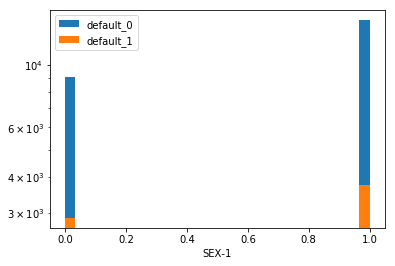

In [6]:
default_1=raw.SEX[raw.default==1].values -1
default_0=raw.SEX[raw.default==0].values -1

print("Женщин в default_0 : {}".format(default_0.mean()))
print("Женщин в default_1 : {}".format(default_1.mean()))

plt.hist(default_0, bins=30, label="default_0")
plt.hist(default_1, bins=30, label="default_1")
plt.xlabel("SEX-1")
plt.yscale('log')
plt.legend()
plt.show()

Построим доверительный интервал для доли

In [7]:
print("Доверительный интервал для доли женщин с default=0 : {}".format(
    proportion_confint(sum(default_0), 
    default_0.shape[0],
    method = 'wilson')
))
print("Доверительный интервал для доли женщин с default=1 : {}".format(
    proportion_confint(sum(default_1), 
    default_1.shape[0],
    method = 'wilson')
))


Доверительный интервал для доли женщин с default=0 : (0.607889734030124, 0.6203726841910749)
Доверительный интервал для доли женщин с default=1 : (0.5551017630282817, 0.578937581965066)


95% доверительный интервал не пересекается, гипотеза о равенстве гендорного состава может быть отвергнута.

In [8]:
def proportions_diff_confint_ind(sample1, sample2, alpha=0.05):
    z = scipy.stats.norm.ppf(1 - alpha / 2.)

    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)

    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1) / len(sample1) + p2 * (1 - p2) / len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1) / len(sample1) + p2 * (1 - p2) / len(sample2))

    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)

    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2
    P = float(p1 * n1 + p2 * n2) / (n1 + n2)

    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative='two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")

    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))

    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)
    
print("95%% Доверительный интервал для разности долей женщин вернувших и не вернувших кредит: {}".format(
      proportions_diff_confint_ind(default_0, default_1)))
print("Достигаемый уровень занчимости грпотезы о равенстве долей женщин против двусторонней альтернативы: {}".format(
    proportions_diff_z_test(proportions_diff_z_stat_ind(default_0, default_1))))

95%% Доверительный интервал для разности долей женщин вернувших и не вернувших кредит: (0.03363493274962867, 0.060548077974896725)
Достигаемый уровень занчимости грпотезы о равенстве долей женщин против двусторонней альтернативы: 4.47286652161e-12


Гипотеза о равенстве гендерный состава группы людей вернувших и не вернувших кредит отвергается

**Задание 3.** Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


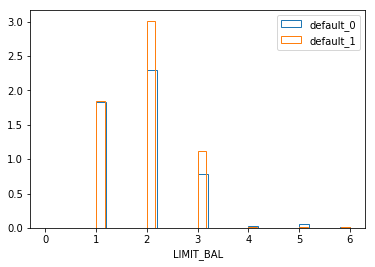

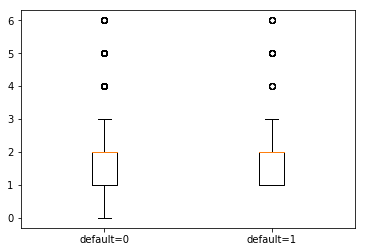

Гипотиза о равенстве сердних книтерием Мана-Уитни отвергается. Достигаемый уровень значимости 7.66175909466e-15 

default=0 mean : 1.84133709981
default=1 mean : 1.89466546112


In [9]:
default_1=raw.EDUCATION[raw.default==1].values
default_0=raw.EDUCATION[raw.default==0].values

plt.hist(default_0, histtype='step', bins=30, label="default_0", normed=True)
plt.hist(default_1, histtype='step', bins=30, label="default_1", normed=True)
plt.xlabel("LIMIT_BAL")
plt.legend()
plt.show()

plt.boxplot([default_0,default_1])
plt.xticks(plt.xticks()[0], ["default=0", "default=1"])
plt.show()

p_value = stats.mannwhitneyu(default_0, default_1)[1]
print("Гипотиза о равенстве сердних книтерием Мана-Уитни{} отвергается. Достигаемый уровень значимости {} \n".format(
      "" if p_value < 0.05 else " не", p_value))
print("default=0 mean : {}".format(np.mean(default_0)))
print("default=1 mean : {}".format(np.mean(default_1)))


Построим таблицу сопряженности, в которой строки обозначают уровень образования, а толбцы, индикатор не возврата долга.
На пересечении количество человек из выборки. Отнормируем каждый элемент на сумму в строке.

In [10]:
V = pd.crosstab(raw.EDUCATION, raw.default)
V_nomed = (V.T/V.sum(axis=1)).T
V_nomed

default,0,1
EDUCATION,,
0,1.000000,0.000000
1,0.807652,0.192348
2,0.762651,0.237349
3,0.748424,0.251576
4,0.943089,0.056911
5,0.935714,0.064286
6,0.843137,0.156863


Из таблицы видно, что все доктора отдают кредит(EDUCATION=0). Чеще всего не отдают долг те, кто закончил школу (EDUCATION=3)

Проверим гипотезу о том, что образование не влияет на то, вернет ли человек долг применяя статистику хи-квадрат.

In [11]:
chi, p_value, dof, expected = stats.chi2_contingency(V)
print('Гипотеза о независимости возврата долга от уровня образования отвергается p-value = {}.'.format(p_value))
print('Разница между V и expected')
V-expected

Гипотеза о независимости возврата долга от уровня образования отвергается p-value = 1.23326262454e-32.
Разница между V и expected


default,0,1
EDUCATION,,
0,3.0968,-3.0968
1,305.4020,-305.4020
2,-226.5640,226.5640
3,-149.3596,149.3596
4,20.2076,-20.2076
5,43.9360,-43.9360
6,3.2812,-3.2812


**Задание 4.** Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

Оба параметра являются категориальными. В качестве меры зависимости можно исмользовать коэффициент V Крамера.
Коэфициент принимает значение от 0 до 1. 0 соответствует полному отсутствию взаимосвязи, 1 — совпадению переменных.

In [12]:

V = pd.crosstab(raw.MARRIAGE, raw.default)
V_nomed = (V.T/V.sum(axis=1)).T
V_nomed

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - (float(k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
print("V мера крамера: {}".format(cramers_corrected_stat(V.values)))

V мера крамера: 0.0329961087761


Можено сделать вывод, что параметры практически не связаны.

**Задание 5.** Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте 
следующие гипотезы:

a) о равенстве медианных значений возрастов людей 

b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

Как и в 1ой задаче используем bootstrap и критерий Мана-Уитни

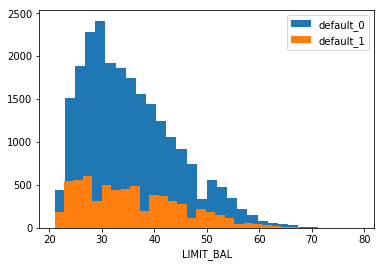

95% доверительный интревал для разности медиан : [0. 1.]
Гипотиза о равенстве сердних книтерием Мана-Уитни не отвергается. Достигаемый уровень значимости 0.186251771745 

95% доверительный интревал для среднего методом bootstrap для default_1 : [35.49689572 35.9712289 ]
95% доверительный интревал для среднего методом bootstrap для default_0 : [35.30355354 35.53344462]


In [13]:
default_1=raw.AGE[raw.default==1].values
default_0=raw.AGE[raw.default==0].values

plt.hist(default_0, bins=30, label="default_0")
plt.hist(default_1, bins=30, label="default_1")
plt.xlabel("LIMIT_BAL")
# plt.yscale('log')
plt.legend()
plt.show()

default_0_medians = list(map(np.median, get_bootstrap_samples(default_0, 1000)))
default_1_medians = list(map(np.median, get_bootstrap_samples(default_1, 1000)))

delta_medians = list(map(lambda x: x[1] - x[0], zip(default_0_medians, default_1_medians)))

print("95% доверительный интревал для разности медиан : {}".format(stat_intervals(delta_medians, 0.05)))

p_value = stats.mannwhitneyu(default_0, default_1)[1]
print("Гипотиза о равенстве сердних книтерием Мана-Уитни{} отвергается. Достигаемый уровень значимости {} \n".format(
      "" if p_value < 0.05 else " не", p_value))

default_0_means = list(map(np.mean, get_bootstrap_samples(default_0, 1000)))
default_1_means = list(map(np.mean, get_bootstrap_samples(default_1, 1000)))

print("95% доверительный интревал для среднего методом bootstrap для default_1 : {}".format(stat_intervals(default_1_means, 0.05)))
print("95% доверительный интревал для среднего методом bootstrap для default_0 : {}".format(stat_intervals(default_0_means, 0.05)))


Разница в возрасте менее одгого года не имеет практической значимости